In [4]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import math
import cartopy.crs as ccrs
import cartopy.feature as cf
import os
import cdsapi
from datetime import datetime, timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [5]:
climatology = xr.open_dataset('/nobackup/users/lulur/Daily_hist_temps/air.2m.day.1981-2010.ltm.nc')
climatology.coords['dayofyear'] = climatology.time.dt.dayofyear
climatology_doy = climatology.drop('time')

/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime o

In [ ]:
climatology

In [ ]:
def load_temps(year):
    dataset = xr.open_dataset('/nobackup/users/lulur/Daily_hist_temps/air.2m.gauss.'+str(year)+'.nc')
    return dataset

In [ ]:
def find_anomalies_draft(year):
    daily_temps = load_temps(year)
    daily_temps.coords['dayofyear'] = daily_temps.time.dt.dayofyear
    daily_temps_doy = daily_temps.drop('time')
    daily_temps['anomalies'] = daily_temps_doy['air']-climatology_doy['air']
    return daily_temps

def find_anomalies(year):
    daily_temps = load_temps(year)
    daily_temps.coords['dayofyear'] = daily_temps.time.dt.dayofyear
    daily_temps_copy = daily_temps.copy()
    time = daily_temps_copy.time
    daily_temps = daily_temps.drop('time')
    air = daily_temps.air
    if air.shape[0]>365:
        air = air.where(air.dayofyear!=air.dayofyear[60], drop=True)
        time = time.where(time.dayofyear!=time.dayofyear[59], drop=True)
    daily_anomalies = xr.Dataset(
        data_vars=dict(
            air=(["time","lat", "lon"], air)
            ),
        coords=dict(
            lon=(["lon"], daily_temps.lon),
            lat=(["lat"], daily_temps.lat),
            time=time))
        
    daily_anomalies['anomalies'] = air-climatology_doy['air']
    daily_anomalies = daily_anomalies.drop('dayofyear')
    return daily_anomalies

In [ ]:
data1979 = find_anomalies(1979)
data1980 = find_anomalies(1980)
histdata = xr.concat((data1979,data1980),dim='time')
years = np.arange(1981,2020)
for year in years:
    data_yr = find_anomalies(year)
    histdata = xr.concat((histdata,data_yr),dim='time') 

delayed_obj = histdata.to_netcdf(path=f"/nobackup/users/lulur/NCEPNCAR_historical_anomalies.nc", mode='w', compute=False, engine='netcdf4', format='NETCDF4')
print(f"writing data to /nobackup/users/lulur/NCEPNCAR_historical_anomalies.nc")

with progress.ProgressBar():
    results = delayed_obj.compute()

In [6]:
histdata = xr.open_dataset('/nobackup/users/lulur/NCEPNCAR_historical_anomalies.nc')

In [7]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def alaska_mean(ds):
    lat_slice = ds.sel(lat=slice(75,55))
    ak_slice = lat_slice.sel(lon=slice(188,255))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims)

def ne_america_mean(ds):
    lat_slice = ds.sel(lat=slice(45,30))
    ak_slice = lat_slice.sel(lon=slice(268,288))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims)

def arctic_mean(ds):
    lat_slice = ds.sel(lat=slice(90,60))
    lat = lat_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(lat_slice.dims) - {'time'}
    return (lat_slice * weight).mean(other_dims)

In [8]:
#Now we calculate the mean air temperatures and temperature anomalies for each region
print('calculating global mean')
gmsts = global_mean(histdata)
print('calculating alaska mean')
akmsts = alaska_mean(histdata)
print('calculating arctic mean')
arcmsts = arctic_mean(histdata)
print('calculating northeast america mean')
ne_amsts = ne_america_mean(histdata)


regions= ('Global','Alaska','Arctic','NE_America')
msts = (gmsts, akmsts, arcmsts, ne_amsts)

calculating global mean
calculating alaska mean
calculating arctic mean
calculating northeast america mean


In [ ]:
akmsts

In [9]:
#calculate the mean and standard deviation of surface temperatures for each region over the whole period
means = []
stds = []
for region_mst in msts:
    slice_mst = region_mst.sel(time=slice('1981-01-01', '2010-12-31'))
    region_means = []
    region_stds = []
    monthday = []
#    days = []
    for month, mdata in slice_mst.groupby('time.month'):
        for day, data in mdata.groupby('time.day'):
            temps = data['air']
            #print(temps)
            meantemp = temps.mean('time')
            stdtemp = temps.std('time')
            region_means.append(float(meantemp))
            region_stds.append(float(stdtemp))
            monthday.append((month,day))
    means.append(region_means)
    stds.append(region_stds)

In [10]:
#Calculate the number of standard deviations from mean for every day in the dataset
hist_stdevs = []
for r in range(4):
    region_temp_stdev = []
    years = []
    print('calculating for region ',regions[r])
    for year, ydata in msts[r].groupby('time.year'):
        for month, mdata in ydata.groupby('time.month'):
            for day, data in mdata.groupby('time.day'):
                index = monthday.index((month,day))
                stdev = stds[r][index]
                n_stdev = float(data['anomalies'])/stdev
                region_temp_stdev.append(n_stdev)
                years.append(year)
    hist_stdevs.append(region_temp_stdev)


calculating for region  Global
calculating for region  Alaska
calculating for region  Arctic
calculating for region  NE_America


In [22]:
#put the standard deviation data into a dataset for easier handling
ds_stdev= xr.Dataset(
        data_vars=dict(
            g_stdev=(["time"], hist_stdevs[0]),
            ak_stdev=(["time"], hist_stdevs[1]),
            arc_stdev=(["time"], hist_stdevs[2]),
            neam_stdev=(["time"], hist_stdevs[3]),
            
            ),
        coords=dict(time=msts[0]['time']))

ds_stdev

delayed_obj = ds_stdev.to_netcdf(path=f"/nobackup/users/lulur/NCEPNCAR_historical_anomaly_stdev.nc", mode='w', compute=False, engine='netcdf4', format='NETCDF4')
print(f"writing data to /nobackup/users/lulur/NCEPNCAR_historical_anomaly_stdev.nc")

with progress.ProgressBar():
    results = delayed_obj.compute()

writing data to /nobackup/users/lulur/NCEPNCAR_historical_anomaly_stdev.nc
[########################################] | 100% Completed |  0.1s


In [12]:
ds_stdev

<xarray.Dataset>
Dimensions:     (time: 14965)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    g_stdev     (time) float64 0.03958 -0.06034 -0.04433 ... 2.661 2.181 2.385
    ak_stdev    (time) float64 0.8036 0.8863 0.9764 ... -0.2229 0.6332 1.028
    arc_stdev   (time) float64 -0.1604 -0.2266 -0.07179 ... 0.4598 0.4357 0.1302
    neam_stdev  (time) float64 1.471 -0.5519 -2.106 -1.429 ... 1.99 1.406 0.1889

In [33]:
#Calculating the number of days above 2 standard deviations for each region for each month of each year
years = []

g_n_2sig_days = {}
ak_n_2sig_days = {}
arc_n_2sig_days = {}
neam_n_2sig_days = {}
for i in range(1,13):
    #for each month, create a dictionary that stores how many >2sig days per that month of each year
    g_n_2sig_days[i]=[]
    ak_n_2sig_days[i]=[]
    arc_n_2sig_days[i]=[]
    neam_n_2sig_days[i]=[]



for year, ydata in ds_stdev.groupby('time.year'):
    years.append(year)
    #iterate over each month of each year, adding the monthly # to the lists stored in the dictionaries
    #those lists will go in the datasets at the end
    for m, mdata in ydata.groupby('time.month'):
        g_n = mdata['g_stdev'].where(np.fabs(mdata['g_stdev'])>2,drop=True).shape[0]
        g_n_2sig_days[m].append(g_n)
        ak_n = mdata['ak_stdev'].where(np.fabs(mdata['ak_stdev'])>2,drop=True).shape[0]
        ak_n_2sig_days[m].append(ak_n)
        arc_n = mdata['arc_stdev'].where(np.fabs(mdata['arc_stdev'])>2,drop=True).shape[0]
        arc_n_2sig_days[m].append(arc_n)
        neam_n = mdata['neam_stdev'].where(np.fabs(mdata['neam_stdev'])>2,drop=True).shape[0]
        neam_n_2sig_days[m].append(neam_n)
    

months_ds = {}

for i in range(1,13):
    #initialize a dataset for each month
    n_2sig= xr.Dataset(
        data_vars=dict(
            global_n2sig=(["year"], g_n_2sig_days[i]),
            alaska_n2sig=(["year"], ak_n_2sig_days[i]),
            arctic_n2sig=(["year"], arc_n_2sig_days[i]),
            ne_america_n2sig=(["year"], neam_n_2sig_days[i]),
            
            ),
        coords=dict(year=years))
    months_ds[i]= n_2sig

In [ ]:
months = ['','January','February','March','April','May','June','July','August','September','October','November','December']
#plot the number of days above 2sigma by region and month
for i in range(1,13):
    n_2sig = months_ds[i]
    plt.figure(figsize=(8,6))
    plt.plot(n_2sig['year'],n_2sig['global_n2sig'],label='Global')
    plt.plot(n_2sig['year'],n_2sig['alaska_n2sig'],label='Alaska')
    plt.plot(n_2sig['year'],n_2sig['arctic_n2sig'],label='Arctic')
    plt.plot(n_2sig['year'],n_2sig['ne_america_n2sig'],label='NE America')
    plt.title('# Days Outside of 2 stdev Temperature Anomaly in '+ months[i])
    plt.xlabel('Year')
    plt.legend()
    plt.ylabel('# Days above 2 Standard Deviations')
    plt.savefig('./figures/NCEP_NCAR_anomalies/monthly_ndays_2sig/n_2sig_days_'+months[i]+'.png')

In [14]:
#Calculating the number of days above 2 standard deviations for each region for each year

years = []
g_n_2sig_days = []
ak_n_2sig_days = []
arc_n_2sig_days = []
neam_n_2sig_days = []

for year, ydata in ds_stdev.groupby('time.year'):
    g_n = ydata['g_stdev'].where(np.fabs(ydata['g_stdev'])>2,drop=True).shape[0]
    g_n_2sig_days.append(g_n)
    ak_n = ydata['ak_stdev'].where(np.fabs(ydata['ak_stdev'])>2,drop=True).shape[0]
    ak_n_2sig_days.append(ak_n)
    arc_n = ydata['arc_stdev'].where(np.fabs(ydata['arc_stdev'])>2,drop=True).shape[0]
    arc_n_2sig_days.append(arc_n)
    neam_n = ydata['neam_stdev'].where(np.fabs(ydata['neam_stdev'])>2,drop=True).shape[0]
    neam_n_2sig_days.append(neam_n)
    years.append(year)

In [15]:
#putting the output of the above cell into a dataset for easier handling
n_2sig= xr.Dataset(
        data_vars=dict(
            g_n2sig=(["year"], g_n_2sig_days),
            ak_n2sig=(["year"], ak_n_2sig_days),
            arc_n2sig=(["year"], arc_n_2sig_days),
            neam_n2sig=(["year"], neam_n_2sig_days),
            
            ),
        coords=dict(year=years))

n_2sig

<xarray.Dataset>
Dimensions:     (year: 41)
Coordinates:
  * year        (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019
Data variables:
    g_n2sig     (year) int64 19 0 0 40 0 16 8 0 ... 21 20 33 120 290 174 81 208
    ak_n2sig    (year) int64 20 11 40 9 14 16 24 11 ... 13 54 16 36 48 36 22 42
    arc_n2sig   (year) int64 36 4 9 17 8 11 11 12 ... 63 35 23 26 167 65 55 113
    neam_n2sig  (year) int64 26 18 11 14 21 18 17 16 ... 25 24 27 33 11 25 28 13

In [ ]:
#plot the number of days above 2sigma by region
plt.figure(figsize=(8,6))
plt.plot(n_2sig['year'],n_2sig['g_n2sig'],label='Global')
plt.plot(n_2sig['year'],n_2sig['ak_n2sig'],label='Alaska')
plt.plot(n_2sig['year'],n_2sig['arc_n2sig'],label='Arctic')
plt.plot(n_2sig['year'],n_2sig['neam_n2sig'],label='NE America')
plt.title('# Days Above 2 stdev Temperature Anomaly per Year')
plt.xlabel('Year')
plt.legend()
plt.ylabel('# Days above 2 Standard Deviations')
plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_n_2sig_days.png')

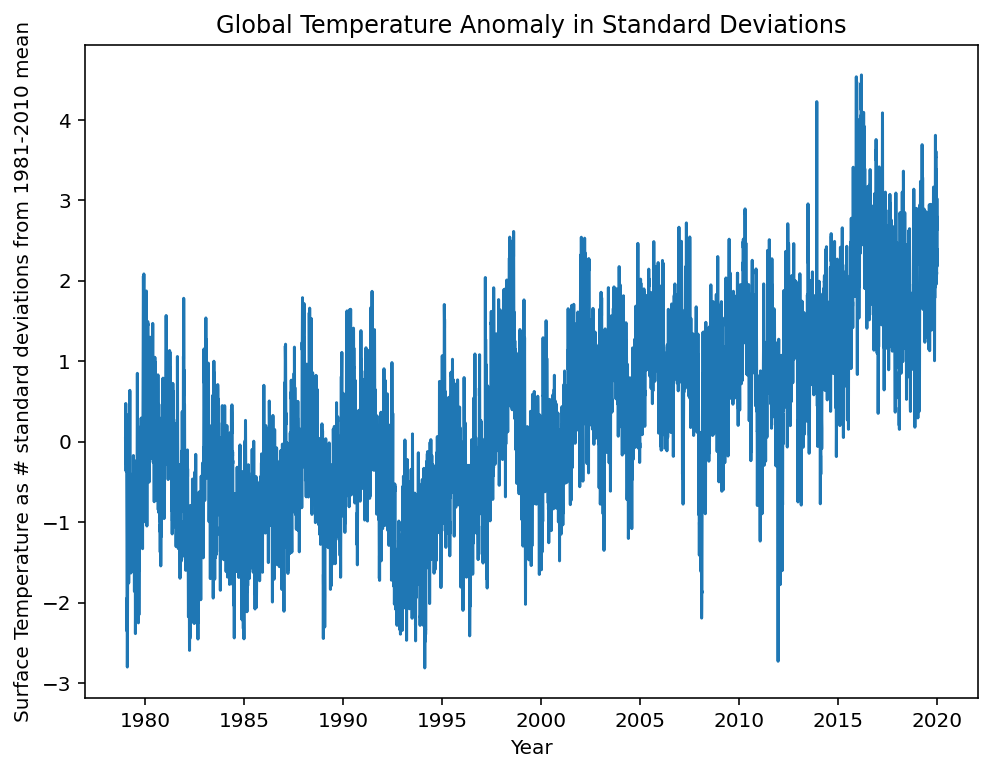

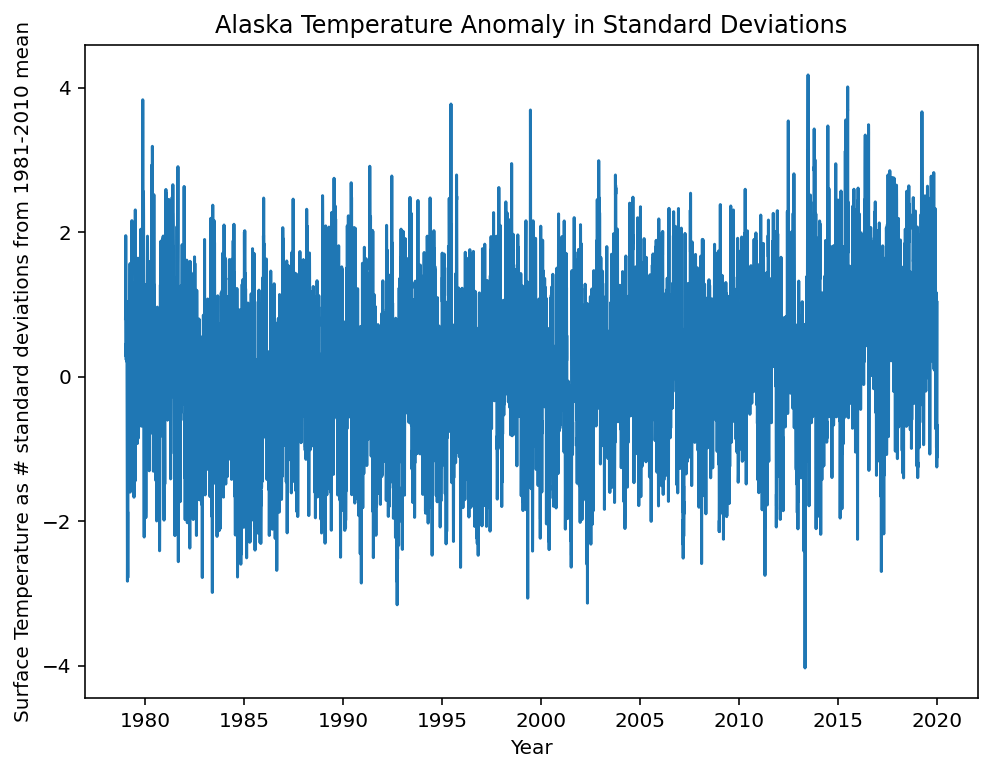

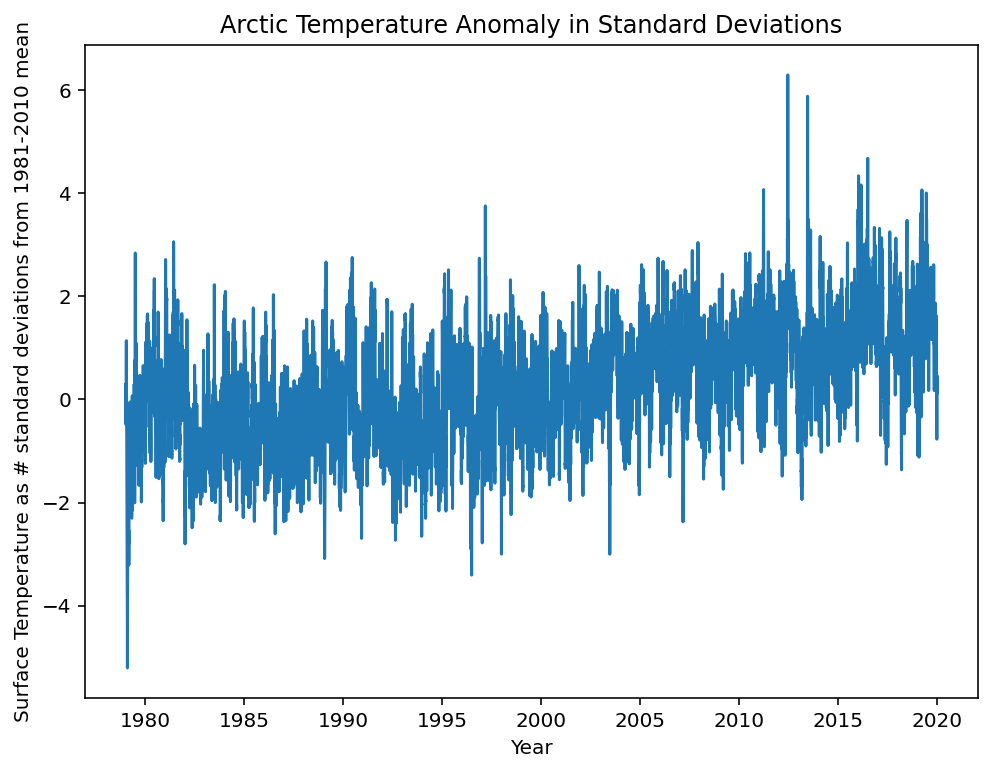

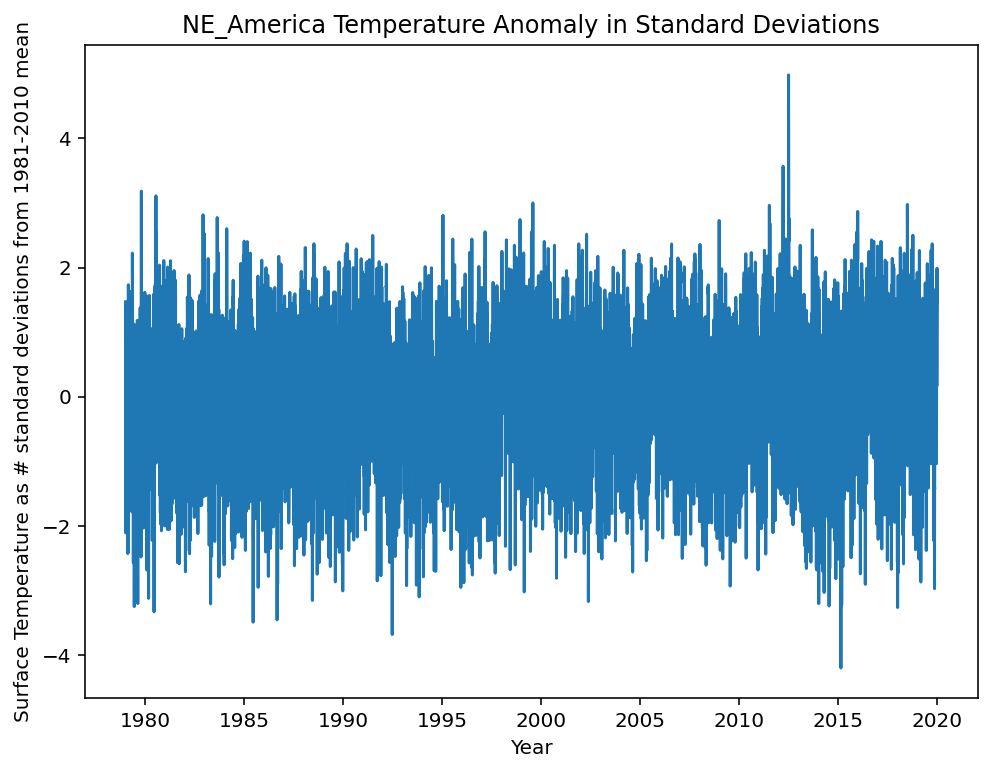

In [13]:
for i in range(4):
    plt.figure(figsize=(8,6))
    plt.plot(msts[i]['time'],hist_stdevs[i])
    plt.title(regions[i]+' Temperature Anomaly in Standard Deviations')
    plt.xlabel('Year')
    plt.ylabel('Surface Temperature as # standard deviations from 1981-2010 mean')
    plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_anomaly_stdev_' + regions[i]+'.png')

In [ ]:
#calculate regional climatologies
print('calculating global mean')
g_clim = global_mean(climatology['air'])
print('calculating alaska mean')
ak_clim = alaska_mean(climatology['air'])
print('calculating arctic mean')
arc_clim = arctic_mean(climatology['air'])
print('calculating northeast america mean')
ne_am_clim = ne_america_mean(climatology['air'])

clims = (g_clim,ak_clim,arc_clim,ne_am_clim)

In [ ]:
timeslice = np.asarray(histdata['time'])
type(timeslice)

In [ ]:
for i in range(4):
    plt.figure(figsize=(10,8))
    #timeslice = data_arrs[i].sel(time=slice('1989-01-01', '1995-12-31'))
    #timeslice = np.asarray(histdata['time'])
    #time = [i[0].dayofyear for i in data_arrs[i]['time']]
    plt.plot(np.arange(1,366),means[i],label=regions[i]+' calculated mean')
    plt.plot(clims[i]['time'].dt.dayofyear,clims[i],label = regions[i]+' climatology mean')
    #plt.xlim(1990,2000)
    plt.legend()
    plt.title(regions[i]+' standard deviation in surface temperature')
    plt.xlabel('Day Of The Year')
    plt.ylabel(regions[i]+' standard deviation in surface temperature')
    plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_calculated_mean_vs_climatology_mean' + regions[i]+'.png')

In [ ]:


def plot_climatology(data_arrs):
    for i in range(4):
        plt.figure(figsize=(10,8))
        #timeslice = data_arrs[i].sel(time=slice('1989-01-01', '1995-12-31'))
        #timeslice = np.asarray(histdata['time'])
        #time = [i[0].dayofyear for i in data_arrs[i]['time']]
        plt.plot(data_arrs[i]['time'].dt.dayofyear,data_arrs[i],label = regions[i]+' mean surfacetemperature')
        #plt.xlim(1990,2000)
        plt.title(regions[i]+'Mean Surface Air Temperature')
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel(regions[i]+'Daily Mean Temperature Anomaly')
        plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_'+regions[i]+'_mean_airtemp.png')

In [ ]:
plot_climatology(clims)

In [ ]:
plt.figure(figsize=(10,8))
timeslice = arcmsts.sel(time=slice('1989-01-01', '1995-12-31'))
#timeslice = np.asarray(histdata['time'])
plt.plot(timeslice['time'],timeslice['anomalies'],label = 'Arctic mean temperature anomaly')
#plt.xlim(1990,2000)
plt.title('Arctic Mean Temperature Anomaly')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Arctic Daily Mean Temperature Anomaly')
#plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_arctic_mean_anomalies.png')

In [ ]:
plt.figure(figsize=(10,8))
#timeslice = histdata.sel(time=slice('1979-01-01', '2020-12-31')).to_array
#timeslice = np.asarray(histdata['time'])
plt.plot(gmsts['time'],gmsts['anomalies'],label = 'global mean temperature anomaly')
#plt.xlim(1980,2100)
plt.title('Global Mean Temperature Anomaly')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Global Daily Mean Temperature Anomaly')
plt.savefig('./figures/NCEP_NCAR_anomalies/NCEPNCAR_global_mean_anomalies.png')